# End to end multi class Sports image ID Classification

This notebook builds an end to end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1.  Problem

Idenifying the sport by image given.

Goal of teaching the machine to ID each sports out there.

## 2. Data

The Data I am using is from Kaggle's Sports Images Classification competition.

https://www.kaggle.com/competitions/logical-rythm-2k20-sports-image-classification/overview

## 3. Evaluation

Train your model on images given in train.zip , use any deep neural network architecture to achieve the highest accuracy

## 4. Features

Some information about the data:
* Dealing with images (unstructured data) so it's would be best to use deep learning/ transfer learning.
* There are 11,040 images in the training set
(these images have labels)
* There are 2,760 images in the test set (these images have no labels)

# Get the workspace ready
* Import TensorFlow 2.x 
* Import TensorFlow Hub 
* Make sure I am using a GPU 

In [64]:
# Import TensorFlow into Colab
import tensorflow as tf
import tensorflow_hub as hub

print("TF version", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU is available" if tf.config.list_physical_devices("GPU") else "Not available")

TF version 2.12.0
TF Hub version: 0.13.0
GPU is available


## Getting our data ready (turning into Tensors)
With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [65]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Sport_ID/train_labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                image     sports
count           11040      11040
unique          11040         22
top     ./train/0.jpg  badminton
freq                1        698
           image      sports
0  ./train/0.jpg    baseball
1  ./train/1.jpg    formula1
2  ./train/2.jpg     fencing
3  ./train/3.jpg      motogp
4  ./train/4.jpg  ice_hockey


In [66]:
labels_csv.head()

,image,sports
0,./train/0.jpg,baseball
1,./train/1.jpg,formula1
2,./train/2.jpg,fencing
3,./train/3.jpg,motogp
4,./train/4.jpg,ice_hockey


<Axes: >

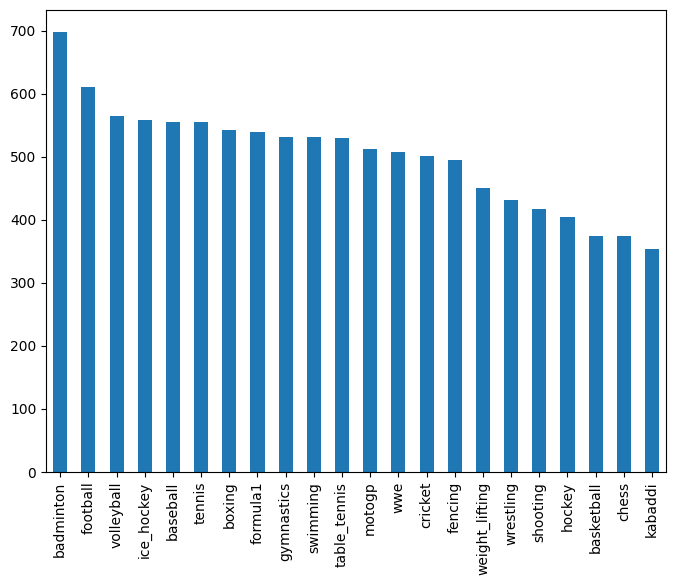

In [67]:
# How many images are there of each sport?
labels_csv["sports"].value_counts().plot.bar(figsize=(8, 6))

In [68]:
# What's the median number of images per sport?
labels_csv["sports"].value_counts().median()

521.5

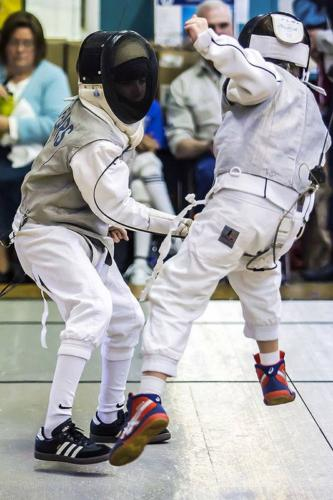

In [69]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Sport_ID/train/train/9907.jpg")

In [70]:
labels_csv["sports"][9907]

'fencing'

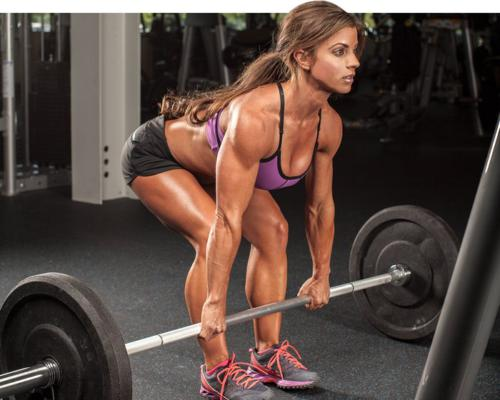

In [71]:
Image("drive/MyDrive/Sport_ID/train/train/1982.jpg")

In [72]:
labels_csv["sports"][1982]

'weight_lifting'

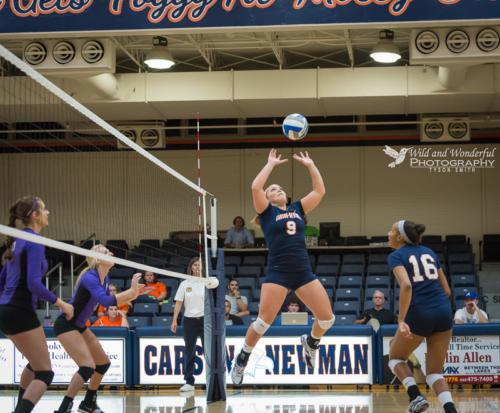

In [73]:
Image("drive/MyDrive/Sport_ID/train/train/3958.jpg")

In [74]:
labels_csv["sports"][3958]

'volleyball'

## Getting images and their labels
Let's get a list of all of our image file pathnames.

In [75]:
labels_csv.head()

,image,sports
0,./train/0.jpg,baseball
1,./train/1.jpg,formula1
2,./train/2.jpg,fencing
3,./train/3.jpg,motogp
4,./train/4.jpg,ice_hockey


In [76]:
# Create pathnames from image IDs
filenames = ["drive/MyDrive/Sport_ID/train" + fname for fname in labels_csv["image"]]

# Modify file paths to remove the extra period
filenames = [fname.replace("./train", "/train") for fname in filenames]

# Check the first 10
print(filenames[:10])

['drive/MyDrive/Sport_ID/train/train/0.jpg', 'drive/MyDrive/Sport_ID/train/train/1.jpg', 'drive/MyDrive/Sport_ID/train/train/2.jpg', 'drive/MyDrive/Sport_ID/train/train/3.jpg', 'drive/MyDrive/Sport_ID/train/train/4.jpg', 'drive/MyDrive/Sport_ID/train/train/5.jpg', 'drive/MyDrive/Sport_ID/train/train/6.jpg', 'drive/MyDrive/Sport_ID/train/train/7.jpg', 'drive/MyDrive/Sport_ID/train/train/8.jpg', 'drive/MyDrive/Sport_ID/train/train/9.jpg']


In [77]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/Sport_ID/train/train")) == len(filenames):
  print("Filenames match amount of files, Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory.")  

Filenames match amount of files, Proceed.


In [78]:
len(labels_csv)

11040

In [79]:
folder_path = "drive/MyDrive/Sport_ID/train/train/" 

# Get the list of files in the folder
file_list = os.listdir(folder_path)

# Count the number of files
num_files = len(file_list)

print(f"Number of files in the folder: {num_files}")

Number of files in the folder: 11040


## Now got our training image filepaths in a list, preparing the labels.



In [80]:
import numpy as np
labels = labels_csv["sports"].to_numpy() 

labels

array(['baseball', 'formula1', 'fencing', ..., 'football', 'football',
       'formula1'], dtype=object)

In [81]:
# Double checking labels
len(labels)

11040

In [82]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames.")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames.


In [83]:
# Find the unique label values
unique_sports = np.unique(labels)
len(unique_sports)

22

In [84]:
unique_sports

array(['badminton', 'baseball', 'basketball', 'boxing', 'chess',
       'cricket', 'fencing', 'football', 'formula1', 'gymnastics',
       'hockey', 'ice_hockey', 'kabaddi', 'motogp', 'shooting',
       'swimming', 'table_tennis', 'tennis', 'volleyball',
       'weight_lifting', 'wrestling', 'wwe'], dtype=object)

In [85]:
# Turn a single label into an array of booleans
print(labels[1990])
labels[1990] == unique_sports

cricket


array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [86]:
# Turn every label into a boolean array
boolean_labels = [label == unique_sports for label in labels]
boolean_labels[:2]

[array([False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False]),
 array([False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False])]

In [87]:
len(boolean_labels)

11040

In [88]:
# Turning boolean array into integers
print(labels[1999]) # original label
print(np.where(unique_sports == labels[0])) # index where label occurs
print(boolean_labels[1999].argmax()) # index where label occurs in boolean array
print(boolean_labels[1999].astype(int)) # there will be a 1 where the sample label occurs

boxing
(array([1]),)
3
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [89]:
print(labels[2])
print(boolean_labels[2].astype(int))

fencing
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [90]:
boolean_labels[:2]

[array([False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False]),
 array([False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False])]

In [91]:
filenames[:10]

['drive/MyDrive/Sport_ID/train/train/0.jpg',
 'drive/MyDrive/Sport_ID/train/train/1.jpg',
 'drive/MyDrive/Sport_ID/train/train/2.jpg',
 'drive/MyDrive/Sport_ID/train/train/3.jpg',
 'drive/MyDrive/Sport_ID/train/train/4.jpg',
 'drive/MyDrive/Sport_ID/train/train/5.jpg',
 'drive/MyDrive/Sport_ID/train/train/6.jpg',
 'drive/MyDrive/Sport_ID/train/train/7.jpg',
 'drive/MyDrive/Sport_ID/train/train/8.jpg',
 'drive/MyDrive/Sport_ID/train/train/9.jpg']

### Creating own validation set
Since the dataset from Kaggle doesn't come with a validation set, I'll going to create our own.



In [92]:
# Setup X & y variables
X = filenames
y = boolean_labels

Going to start off experimenting with ~1000 images and increase as needed.

In [93]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [94]:
# Splitting our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [95]:
# Let's have a peek at the training data
X_train[:5], y_train[:2]

(['drive/MyDrive/Sport_ID/train/train/29.jpg',
  'drive/MyDrive/Sport_ID/train/train/535.jpg',
  'drive/MyDrive/Sport_ID/train/train/695.jpg',
  'drive/MyDrive/Sport_ID/train/train/557.jpg',
  'drive/MyDrive/Sport_ID/train/train/836.jpg'],
 [array([False, False, False, False, False,  True, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False]),
  array([False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False,
         False, False, False, False])])

## Preprocessing Images (turning images into Tensors)
To preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, image
3. Turn our image (a jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1).
5. Resize the image to be a shape of (224, 224)
6. Return the modified image


Before we do, let's see what importing an image looks like.

In [96]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[99])
image.shape

(375, 500, 3)

In [97]:
image.max(), image.min()


(255, 0)

In [98]:
image[:8]

array([[[254, 254, 252],
        [253, 253, 251],
        [255, 254, 252],
        ...,
        [251, 251, 251],
        [253, 253, 253],
        [253, 253, 253]],

       [[254, 254, 252],
        [253, 253, 251],
        [255, 254, 252],
        ...,
        [251, 251, 251],
        [254, 254, 254],
        [253, 253, 253]],

       [[255, 255, 253],
        [253, 253, 251],
        [255, 254, 252],
        ...,
        [252, 252, 252],
        [255, 255, 255],
        [254, 254, 254]],

       ...,

       [[255, 255, 253],
        [254, 254, 252],
        [254, 253, 251],
        ...,
        [252, 252, 252],
        [255, 255, 255],
        [254, 254, 254]],

       [[255, 255, 253],
        [254, 254, 252],
        [254, 253, 251],
        ...,
        [251, 251, 251],
        [254, 254, 254],
        [253, 253, 253]],

       [[255, 255, 253],
        [254, 254, 252],
        [253, 252, 250],
        ...,
        [251, 251, 251],
        [253, 253, 253],
        [253, 253, 253]]

In [99]:
# turn image into a tensor
tf.constant(image)[:8]

<tf.Tensor: shape=(8, 500, 3), dtype=uint8, numpy=
array([[[254, 254, 252],
        [253, 253, 251],
        [255, 254, 252],
        ...,
        [251, 251, 251],
        [253, 253, 253],
        [253, 253, 253]],

       [[254, 254, 252],
        [253, 253, 251],
        [255, 254, 252],
        ...,
        [251, 251, 251],
        [254, 254, 254],
        [253, 253, 253]],

       [[255, 255, 253],
        [253, 253, 251],
        [255, 254, 252],
        ...,
        [252, 252, 252],
        [255, 255, 255],
        [254, 254, 254]],

       ...,

       [[255, 255, 253],
        [254, 254, 252],
        [254, 253, 251],
        ...,
        [252, 252, 252],
        [255, 255, 255],
        [254, 254, 254]],

       [[255, 255, 253],
        [254, 254, 252],
        [254, 253, 251],
        ...,
        [251, 251, 251],
        [254, 254, 254],
        [253, 253, 253]],

       [[255, 255, 253],
        [254, 254, 252],
        [253, 252, 250],
        ...,
        [251, 251, 251]

## After seeing what an image looks like as a Tensor, will make a function to preprocess them.

I'll create a function to:

Take an image filepath as input
Use TensorFlow to read the file and save it to a variable, image
Turn our image (a jpg) into Tensors
Normalize the image (convert color channel values from from 0-255 to 0-1).
Resize the image to be a shape of (224, 224)
Return the modified image


In [100]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning the data into batches


In [101]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
 
  image = process_image(image_path)
  return image, label

In [103]:
# Demo of the above
(process_image(X[1190]), tf.constant(y[1190]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.2491517 , 0.25699484, 0.237387  ],
         [0.25351018, 0.2613533 , 0.24174546],
         [0.25649706, 0.2643402 , 0.24473237],
         ...,
         [0.17103468, 0.19064252, 0.16711311],
         [0.18140757, 0.18925071, 0.177486  ],
         [0.18447171, 0.19231485, 0.18055014]],
 
        [[0.25012895, 0.2579721 , 0.23836426],
         [0.25063902, 0.25848216, 0.23887432],
         [0.26272473, 0.27056786, 0.25096002],
         ...,
         [0.24027197, 0.2598798 , 0.2363504 ],
         [0.24782039, 0.25566354, 0.24389882],
         [0.24948244, 0.25732556, 0.24556087]],
 
        [[0.24981424, 0.25765738, 0.23804954],
         [0.26038167, 0.2682248 , 0.24861696],
         [0.2596366 , 0.26747975, 0.24787189],
         ...,
         [0.2600928 , 0.27058825, 0.2500963 ],
         [0.25882354, 0.27577907, 0.25490198],
         [0.2627451 , 0.27970064, 0.25882354]],
 
        ...,
 
        [[0.7785096 , 0.5000782 

Will turn the data into tuples of Tensors in the form: (image, label), let's make a function to turn all of the data (X & y) into batches.



In [104]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [105]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [106]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 22), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 22), dtype=tf.bool, name=None)))

## Visualizing Data Batches
The data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them.



In [108]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image 
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")



In [109]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 22), dtype=tf.bool, name=None))>

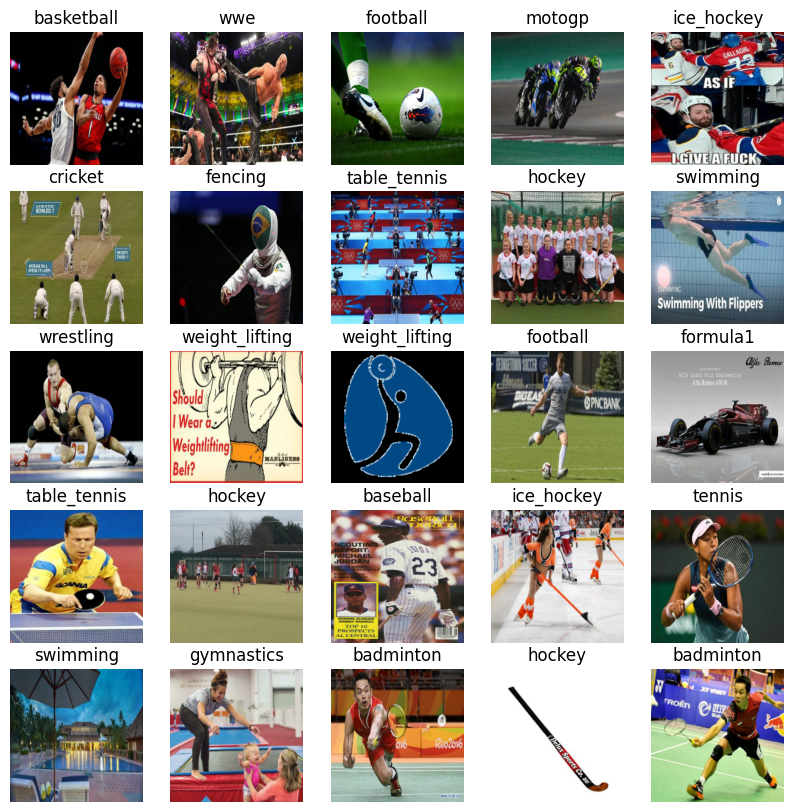

In [110]:
 # Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

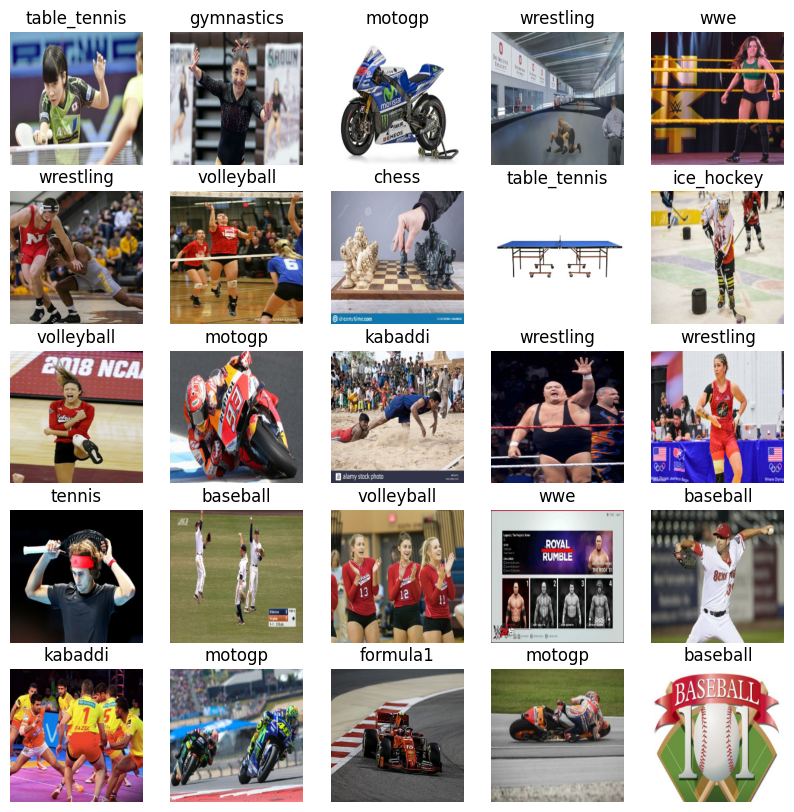

In [111]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

### Building a model
Before building a model, there are a few things that needs to define:

The input shape (our images shape, in the form of Tensors) to the model.
The output shape (image labels, in the form of Tensors) of the model.
The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [113]:
IMG_SIZE

224

In [114]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, heigh, weidth, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL form TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [115]:
INPUT_SHAPE

[None, 224, 224, 3]

Now I got the inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model.

Knowing this, let's create a function which:

Takes the input shape, output shape and the model I've chosen as parameters.
Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
Compiles the model (says it should be evaluated and improved).
Builds the model (tells the model the input shape it'll be getting).
Returns the model.
All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [116]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [117]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 22)                22044     
                                                                 
Total params: 5,454,757
Trainable params: 22,044
Non-trainable params: 5,432,713
_________________________________________________________________


# Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

I'll create two callbacks, one for TensorBoard which helps track the models progress and another for early stopping which prevents the model from training for too long.

# TensorBoard Callback

To setup a TensorBoard callback, I need to do 3 things:

1. Load the TensorBoard notebook extension 
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to the model's fit() function. 
3. Visualize the models training logs with the %tensorboard magic function (will do this after model training).
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [118]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [120]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Sport_ID/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.


https://www.tensorFlow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [121]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=3)

## Training a model (on subset of data)

The first model is only going to train on 1000 images, to make sure everything is working.

In [122]:
NUM_EPOCHS = 100 #@param {type: "slider", min:10, max:100, step:10}

In [124]:
# Check to make sure the still running on a GPU
print("GPU", "available (YES!)" if tf.config.list_physical_devices("GPU") else "not available :")

GPU available (YES!)


### Let's create a function which trains a model

* Create a model using create_model()
* Setup a TensorBoard callback using create_tensorboard_callback()
* Call the fit() function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use
Return model